Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)


2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels='inferred',
  batch_size=batch_size,
  image_size=(img_height, img_width),
  seed=123,
  validation_split=0.2,
  subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels='inferred',
  batch_size=batch_size,
  image_size=(img_height, img_width),
  seed=123,
  validation_split=0.2,
  subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

32
32


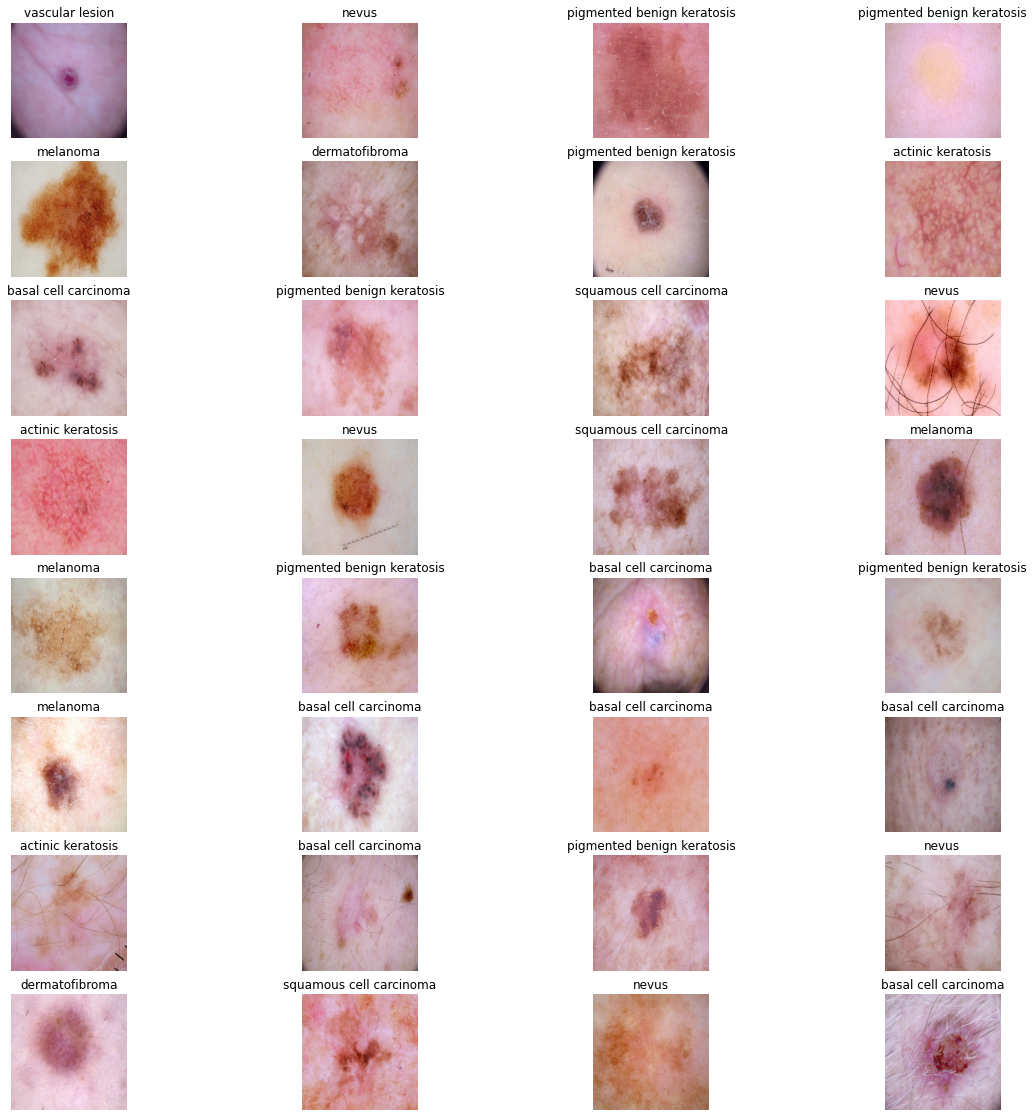

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))
  for i in range(32):
    ax = plt.subplot(8, 4, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
#overlaps data preprocessing and model execution while training., Speed up training
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
num_classes = 9
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1.0/255, input_shape=(img_height, img_width, 3)),

  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  #sliding over the feature map and extract tiles of a specified size.
  #downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
  layers.MaxPooling2D(),

  #2D convolution layer.
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  #Flatting =  converting into 1D feature vector. Flattens the structure to create a single long feature vector
  layers.Flatten(),

  #fully connected layer (Dense Layer)
  #A hidden layer in which each node is connected to every node in the subsequent hidden layer
  layers.Dense(128, activation='relu'),
  
  #Dense layer is the only actual network layer feeding alll outputs from previous layer to all its' neurons implementing the operation: output = activation(dot(input, kernel)). its representing a matrix vector multiplication.
  layers.Dense(num_classes)                    
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

Selecting Adam optimizer because it achieves good results fast. This algorithm is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications in computer vision. It combines the advantages of two other extensions of stochastic gradient descent : AdaGrad and RMSProp.

CrossEntropyLoss is the appropriate loss function for a classification model that outputs raw scores for each class.

Accuracy is chosen as the metric to determine the model performance.

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 296s 1s/step - loss: 2.0981 - accuracy: 0.2416 - val_loss: 1.8902 - val_accuracy: 0.3043
Epoch 2/20
56/56 [==============================] - 1s 24ms/step - loss: 1.6839 - accuracy: 0.3973 - val_loss: 1.5382 - val_accuracy: 0.4698
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5031 - accuracy: 0.4682 - val_loss: 1.4262 - val_accuracy: 0.5190
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3925 - accuracy: 0.5134 - val_loss: 1.4604 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3094 - accuracy: 0.5413 - val_loss: 1.3568 - val_accuracy: 0.5369
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1943 - accuracy: 0.5848 - val_loss: 1.3646 - val_accuracy: 0.5436
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1282 - accuracy: 0.5915 - val_loss: 1.3650 - val_accuracy: 0.5414
Epoch 8/20
56

### Visualizing training results

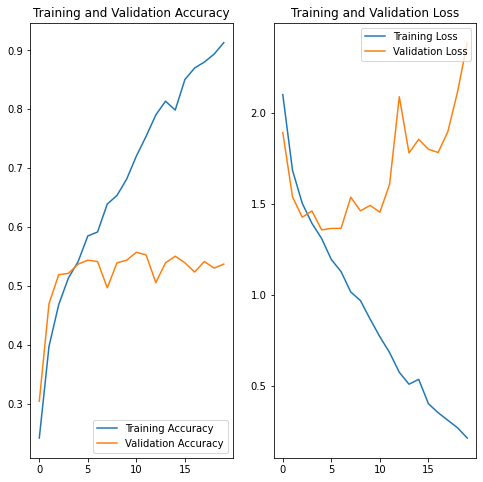

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

**Insights**:
We can observe from the plots that training accuracy and validation accuracy are off by large margin and the model has achieved only around 53% accuracy on the validation set. It's a clear sign of OverFitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 50% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable from 91% to 53% — a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

We will use data augmentation to fight overfitting in training process. It will help to expose the model to more aspects of the data and generalize better. We will be using the layers from tf.keras.layers.experimental.preprocessing.

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                  input_shape=(img_height,
                                                               img_width,
                                                               3)),
     layers.experimental.preprocessing.RandomRotation(0.4),
     layers.experimental.preprocessing.RandomZoom(0.5),
     layers.experimental.preprocessing.RandomContrast(0.5),
     layers.experimental.preprocessing.RandomCrop(img_height, img_width),
     layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    ]
)

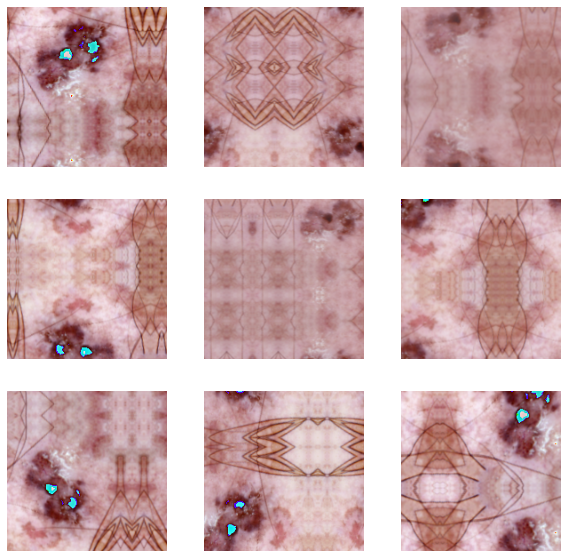

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):  
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model

second model with data augmention


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

num_classes = 9
model = Sequential([
  data_augmentation,

  layers.experimental.preprocessing.Rescaling(1.0/255, input_shape=(img_height, img_width, 3)),

  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  #sliding over the feature map and extract tiles of a specified size.
  #downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
  layers.MaxPooling2D(),
  

  #2D convolution layer.
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Dropout(0.2),
  #Flatting =  converting into 1D feature vector. Flattens the structure to create a single long feature vector
  layers.Flatten(),

  #fully connected layer (Dense Layer)
  #A hidden layer in which each node is connected to every node in the subsequent hidden layer
  layers.Dense(128, activation='relu'),

  #Dense layer is the only actual network layer feeding alll outputs from previous layer to all its' neurons implementing the operation: output = activation(dot(input, kernel)). its representing a matrix vector multiplication.
  layers.Dense(num_classes) 
                  
])



### Compiling the model

In [19]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 37ms/step - loss: 1.9044 - accuracy: 0.3013 - val_loss: 1.8251 - val_accuracy: 0.3378
Epoch 2/20
56/56 [==============================] - 2s 30ms/step - loss: 1.7234 - accuracy: 0.3493 - val_loss: 1.8750 - val_accuracy: 0.3154
Epoch 3/20
56/56 [==============================] - 2s 30ms/step - loss: 1.7041 - accuracy: 0.3465 - val_loss: 1.6493 - val_accuracy: 0.3982
Epoch 4/20
56/56 [==============================] - 2s 30ms/step - loss: 1.6427 - accuracy: 0.3728 - val_loss: 1.6373 - val_accuracy: 0.3714
Epoch 5/20
56/56 [==============================] - 2s 30ms/step - loss: 1.6311 - accuracy: 0.3845 - val_loss: 1.5754 - val_accuracy: 0.4049
Epoch 6/20
56/56 [==============================] - 2s 30ms/step - loss: 1.6031 - accuracy: 0.3906 - val_loss: 1.5731 - val_accuracy: 0.4340
Epoch 7/20
56/56 [==============================] - 2s 30ms/step - loss: 1.6114 - accuracy: 0.3945 - val_loss: 1.5255 - val_accuracy: 0.4541
Epoch 8/20
56

### Visualizing the results

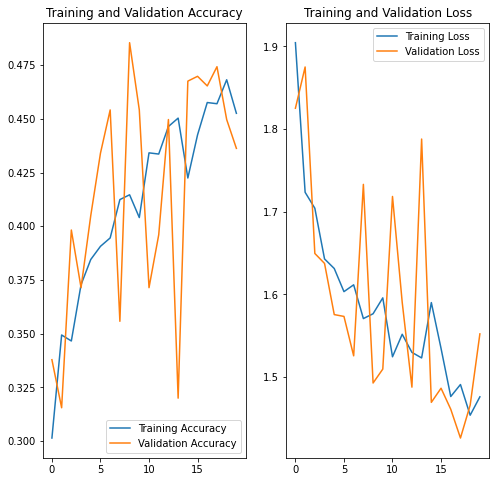

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Insights**:
We can observe from the plots that training accuracy and validation accuracy does not differ by big margin and the model has achieved around 43% accuracy on the validation set with 45% accuracy in training set. We can conclude that there is some improvement compared to previous model and the augmentation helped to control the problem of overfitting. But to improve the model accuracy, we need to handle class imbalance.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [24]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(lesion_list)

2239

In [25]:
dataframe_dict_original = dict(zip(path_list, lesion_list))


In [26]:
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
1,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
2,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
3,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
4,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Skin cancer ISIC The I...,pigmented benign keratosis
2235,/content/gdrive/MyDrive/Skin cancer ISIC The I...,pigmented benign keratosis
2236,/content/gdrive/MyDrive/Skin cancer ISIC The I...,pigmented benign keratosis
2237,/content/gdrive/MyDrive/Skin cancer ISIC The I...,pigmented benign keratosis


Class=0, n=114 (5.092%)
Class=4, n=357 (15.945%)
Class=3, n=438 (19.562%)
Class=8, n=139 (6.208%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=5, n=462 (20.634%)


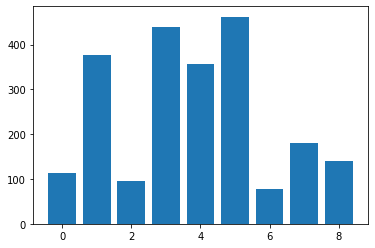

In [27]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
  per = v / len(y) * 100
  print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
Class 6 (seborrheic keratosis) has the least number of samples (77 samples).
#### - Which classes dominate the data in terms proportionate number of samples?
Class 1,3,4,5 (pigmented benign keratosis, melanoma, basal cell carcinoma and nevus) dominating the data in terms proportionate number of samples. Class 5 (pigmented benign keratosis) has 20.6% percentage of sample i.e. 462 samples in the train set


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
#https://github.com/mdbloice/Augmentor
path_to_training_dataset= "/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    ## We are adding 500 samples per class to make sure that none of the classes are sparse.
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F14B90822D0>: 100%|██████████| 500/500 [00:17<00:00, 27.85 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F14B90DE350>: 100%|██████████| 500/500 [00:17<00:00, 27.78 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F14B90FA1D0>: 100%|██████████| 500/500 [00:18<00:00, 27.35 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F14B8771510>: 100%|██████████| 500/500 [01:34<00:00,  5.30 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2601x1909 at 0x7F14BE2A9210>: 100%|██████████| 500/500 [01:22<00:00,  6.08 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F14B9082690>: 100%|██████████| 500/500 [00:18<00:00, 27.63 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F14B87AB350>: 100%|██████████| 500/500 [00:41<00:00, 12.13 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F14B98C1750>: 100%|██████████| 500/500 [00:20<00:00, 24.90 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F14B8721690>: 100%|██████████| 500/500 [00:17<00:00, 28.02 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029141.jpg_d9b0ab76-e3f5-4c4d-88eb-109815744890.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030825.jpg_8bafe115-e54e-48b6-bd2a-52277e9f6f2b.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026702.jpg_e4e79d2f-2deb-47bc-a0b0-4a2d9ed3272f.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030655.jpg_f9d5f4bf-03c3-41b5-a821-7313fe0d92fd.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028314.jpg_c59502bf-b040

In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [34]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [35]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)
new_df

,Path,Label
0,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
1,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
2,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
3,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
4,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
...,...,...
4495,/content/gdrive/MyDrive/Skin cancer ISIC The I...,pigmented benign keratosis
4496,/content/gdrive/MyDrive/Skin cancer ISIC The I...,pigmented benign keratosis
4497,/content/gdrive/MyDrive/Skin cancer ISIC The I...,pigmented benign keratosis
4498,/content/gdrive/MyDrive/Skin cancer ISIC The I...,pigmented benign keratosis


In [36]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

In [37]:
df2['Label'].value_counts()

actinic keratosis             500
nevus                         500
melanoma                      500
vascular lesion               500
seborrheic keratosis          500
squamous cell carcinoma       500
basal cell carcinoma          500
dermatofibroma                500
pigmented benign keratosis    500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [38]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [39]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)



*   layers.experimental.preprocessing.Rescaling is used to normalize data between (0,1) in RGB range [0,255].

*   We have also used Dropout, a form of regularization, to handle overfitting. Adding Dropout to a layer randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process.


*   It takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.






In [41]:
## your code goes here
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = 9
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)



*   Selecting Adam optimizer because it achieves good results fast. This algorithm is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications in computer vision. It combines the advantages of two other extensions of stochastic gradient descent : AdaGrad and RMSProp.

*   CrossEntropyLoss is the appropriate loss function for a classification model that outputs raw scores for each class.
*   Accuracy is chosen as the metric to determine the model performance.




In [42]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [45]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 34s 61ms/step - loss: 1.7173 - accuracy: 0.3372 - val_loss: 1.4527 - val_accuracy: 0.4647
Epoch 2/50
169/169 [==============================] - 4s 24ms/step - loss: 1.3437 - accuracy: 0.4974 - val_loss: 1.2687 - val_accuracy: 0.5464
Epoch 3/50
169/169 [==============================] - 4s 24ms/step - loss: 1.1114 - accuracy: 0.5862 - val_loss: 1.1669 - val_accuracy: 0.5679
Epoch 4/50
169/169 [==============================] - 4s 24ms/step - loss: 0.9571 - accuracy: 0.6491 - val_loss: 1.0365 - val_accuracy: 0.6236
Epoch 5/50
169/169 [==============================] - 4s 24ms/step - loss: 0.8250 - accuracy: 0.6951 - val_loss: 0.9891 - val_accuracy: 0.6526
Epoch 6/50
169/169 [==============================] - 4s 24ms/step - loss: 0.6954 - accuracy: 0.7539 - val_loss: 1.0710 - val_accuracy: 0.6251
Epoch 7/50
169/169 [==============================] - 4s 24ms/step - loss: 0.6045 - accuracy: 0.7864 - val_loss: 0.8529 - val_accuracy: 0.720

#### **Todo:**  Visualize the model results

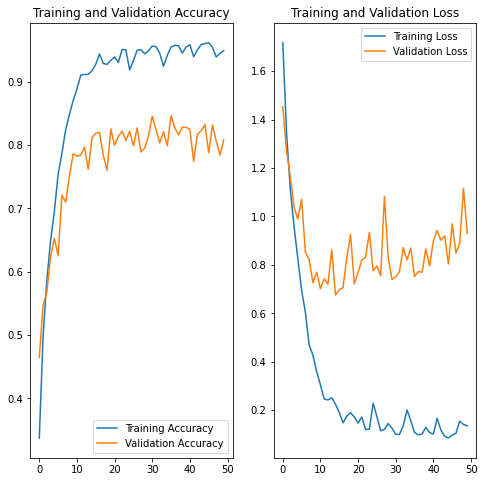

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Augmentor allows us to create an augmentation pipeline, which chains together operations that are applied stochastically, where the parameters of each of these operations are also chosen at random, within a range specified by the user. This means that each time an image is passed through the pipeline, a different image is returned. Depending on the number of operations in the pipeline, and the range of values that each operation has available, a very large amount of new image data can be created in this way.

The balancing of each class using Augmentor has helped to improve the performance of the model drastically. We can see from the plot that both training and validation accuracy increases steadily. Final accuracy achieved for training set is ~94% and validation set is ~80%. We can also infer that Augmentation also helped to control the initial overfitting issue.

In [47]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  labels='inferred',
  label_mode='int',
  batch_size=32,
  class_names=None,
  color_mode='rgb',
  image_size=(img_height, img_width),
  seed=123,
  shuffle=False,
  interpolation='bilinear',
  follow_links=False)

Found 118 files belonging to 9 classes.


Evaluating the model in one of the test image

In [48]:
img_path = '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/melanoma/ISIC_0000036.jpg'
img = keras.preprocessing.image.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
print('Predictions:- ',predictions)

score = tf.nn.relu(predictions[0])
print('Score:- ',score)
print("This image most likely belongs to {} with a {:.2f} prediction score."
    .format(class_names[np.argmax(score)], np.max(score))
)


Predictions:-  [[-17.581715   -1.6570475 -32.66264    15.080465    8.012183    4.8519735
    0.7849261 -24.25605     4.2553873]]
Score:-  tf.Tensor(
[ 0.         0.         0.        15.080465   8.012183   4.8519735
  0.7849261  0.         4.2553873], shape=(9,), dtype=float32)
This image most likely belongs to melanoma with a 15.08 prediction score.


So, the model predicting the image class correctly.
